<a href="https://www.kaggle.com/code/babaksh/rice-classification?scriptVersionId=223229072" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Rice Image Dataset

## **Overview**
The **Rice Image Dataset** is a collection of high-resolution images designed for rice grain classification. It contains images of five different rice varieties, making it useful for machine learning applications in agricultural research, food quality assessment, and automated classification systems.

## **Dataset Details**
- **Total Images**: 75,000  
- **Number of Classes**: 5  
- **Image Size**: 250 × 250 pixels  
- **Format**: JPEG  
- **Grayscale or RGB**: RGB  

## **Classes (Rice Varieties)**
The dataset includes images of the following five types of rice grains:  
1. **Arborio**  
2. **Basmati**  
3. **Ipsala**  
4. **Jasmine**  
5. **Karacadag**  

Each class contains an equal number of images, ensuring balanced data for training machine learning models.

## **Potential Use Cases**
- **Classification Models**: Train deep learning models (e.g., CNNs, ViTs) to classify rice varieties.
- **Feature Extraction**: Extract texture, shape, and color features for distinguishing different rice types.
- **Quality Assessment**: Identify high-quality vs. low-quality grains using automated inspection systems.
- **Agricultural Research**: Analyze grain characteristics to improve production and processing techniques.


# Code Overview

This code imports essential libraries for building and training an image classification model using TensorFlow and Keras.

- **os, numpy, pandas**: For data management and numerical operations.
- **seaborn, matplotlib**: For data visualization and plotting.
- **tensorflow**: Core framework for deep learning tasks, including model building and training.
- **sklearn**: For splitting data and dimensionality reduction (t-SNE).
- **ImageDataGenerator**: For real-time data augmentation.
- **Callbacks (EarlyStopping, ModelCheckpoint)**: To improve training by monitoring performance.

These libraries help preprocess data, define the model, optimize training, and visualize results.


In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Resizing
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.applications import ResNet50
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Flatten
from tensorflow.keras.layers import Activation, MaxPooling2D, GlobalAveragePooling2D, Dropout, Dense

# Image Parameters and Dataset Path

In this step, we define key parameters for preprocessing and model training:

- **Image Size**: Resized to `(224, 224)` for consistency across the dataset.
- **Channels**: Set to `3` (RGB), ensuring compatibility with deep learning models.
- **Batch Size**: `64`, balancing memory usage and training efficiency.
- **Epochs**: `15`, defining the number of training iterations.
- **Learning Rate**: `1e-3`, a standard starting point for optimization.
- **Patience**: `10`, allowing early stopping if validation performance does not improve.

The dataset path is set to the **Rice Image Dataset** location on Kaggle.

In [2]:
# Image parameters
IMG_SIZE = (224, 224)
CHANNELS = 3
BATCH_SIZE = 64
EPOCHS = 15
LEARNING_RATE = 1e-3
PATIENCE = 10

# Paths
dataset_path = "/kaggle/input/rice-image-dataset/Rice_Image_Dataset"

# Data Preparation: Train, Validation, and Test Generators

This step loads the **Rice Image Dataset** and splits it into **training, validation, and test sets** using `image_dataset_from_directory()`.

- **Training Set** (`train_generator`): 
  - 80% of the dataset.
  - Labels are inferred and one-hot encoded (`categorical` mode).
  - Images are resized to `(224, 224)`.
  - Batch size is `64`.

- **Validation Set** (`val_generator`):  
  - 20% of the dataset.
  - Used to monitor model performance during training.

- **Test Set** (`test_generator`):  
  - 10% of the dataset, separate from validation.
  - Used for final evaluation.

A **random seed (1000)** ensures reproducibility of splits.

In [3]:
train_generator = image_dataset_from_directory(
    directory=dataset_path,
    labels='inferred',
    subset='training',
    label_mode='categorical',
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    validation_split=0.2,
    seed=1000
)

val_generator = image_dataset_from_directory(
    directory=dataset_path,
    subset='validation',
    labels='inferred',
    label_mode='categorical',
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    validation_split=0.2,
    seed=1000
)

test_generator = image_dataset_from_directory(
    directory=dataset_path,
    labels='inferred',
    subset='validation',
    label_mode='categorical',
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    validation_split=0.1,
    seed=1000
)

Found 75000 files belonging to 5 classes.
Using 60000 files for training.
Found 75000 files belonging to 5 classes.
Using 15000 files for validation.
Found 75000 files belonging to 5 classes.
Using 7500 files for validation.


# CNN Model Architecture

This Convolutional Neural Network (CNN) is designed for image classification and consists of three convolutional blocks followed by a classification block.

- **First Convolutional Block**: 
  - Uses a 32-filter `Conv2D` layer with a `3x3` kernel and ReLU activation.
  - Applies `BatchNormalization` to stabilize training.
  - Uses `MaxPooling2D` to reduce spatial dimensions.
  - Includes `Dropout (0.3)` to prevent overfitting.

- **Second Convolutional Block**:
  - Expands to 64 filters with similar layers as the first block.
  - `Dropout (0.4)` is used for regularization.

- **Third Convolutional Block**:
  - Uses 128 filters, `BatchNormalization`, and ReLU activation.
  - `MaxPooling2D` downsamples features.
  - `Dropout (0.5)` helps prevent overfitting.

- **Classification Block**:
  - `GlobalAveragePooling2D` followed by `Flatten` reduces feature maps.
  - Fully connected (`Dense`) layers progressively reduce dimensions: `512 → 256 → 128`.
  - `BatchNormalization` and `Dropout` (up to 0.7) improve generalization.
  - Final `Dense` layer with `softmax` activation outputs class probabilities.

This model balances depth and regularization for robust feature extraction and classification.

In [4]:
# Build the CNN model
def build_cnn_model(input_shape, num_classes):
    model = Sequential([
        # First Convolutional Block
        Conv2D(32, (3, 3), padding='same', input_shape=input_shape),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D((2, 2)),
        Dropout(0.3),
        
        # Second Convolutional Block
        Conv2D(64, (3, 3), padding='same'),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D((2, 2)),
        Dropout(0.4),
        
        # Third Convolutional Block
        Conv2D(128, (3, 3), padding='same'),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D((2, 2)),
        Dropout(0.5),
        
        # Classification Block
        GlobalAveragePooling2D(),
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.6),
        Dense(256, activation='relu'),
        Dropout(0.65),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.7),
        Dense(num_classes, activation='softmax')
    ])
    
    return model

# AlexNet Model Architecture

This function implements a variant of the **AlexNet** architecture for image classification, modified for use with TensorFlow/Keras.

- **Input & Preprocessing**:
  - The input is resized to `227x227` to match the original AlexNet dimensions.

- **Feature Extraction (Convolutional Blocks)**:
  - **Block 1**: Uses a `96-filter` convolutional layer with an `11x11` kernel, `stride 4`, followed by `MaxPooling` and `BatchNormalization`.
  - **Block 2**: Expands to `256 filters` with a `5x5` kernel, `same padding`, followed by `MaxPooling` and `BatchNormalization`.
  - **Block 3**: Uses `384 filters` with a `3x3` kernel.
  - **Block 4**: Another `384-filter` convolutional layer with a `3x3` kernel.
  - **Block 5**: Uses `256 filters` with a `3x3` kernel, followed by `MaxPooling`.

- **Classification (Fully Connected Layers)**:
  - `GlobalAveragePooling2D` and `Flatten` prepare features for dense layers.
  - Two fully connected layers with `4096` neurons and `ReLU` activation.
  - `Dropout (0.5)` helps prevent overfitting.
  - A final `Dense` layer with `softmax` activation outputs class probabilities.

This architecture is optimized for large-scale image classification, leveraging deep convolutional layers and fully connected layers for robust feature learning.

In [5]:
def build_alexnet_model(input_shape, num_classes):
    model = tf.keras.Sequential([
        Input(shape=input_shape),
        tf.keras.layers.Resizing(227, 227),
        
        # Block 1
        Conv2D(96, (11, 11), strides=4, activation='relu'),
        MaxPooling2D((3, 3), strides=2),
        BatchNormalization(),
        
        # Block 2
        Conv2D(256, (5, 5), padding='same', activation='relu'),
        MaxPooling2D((3, 3), strides=2),
        BatchNormalization(),
        
        # Block 3
        Conv2D(384, (3, 3), padding='same', activation='relu'),
        
        # Block 4
        Conv2D(384, (3, 3), padding='same', activation='relu'),
        
        # Block 5
        Conv2D(256, (3, 3), padding='same', activation='relu'),
        MaxPooling2D((3, 3), strides=2),
        
        # Classifier
        GlobalAveragePooling2D(),
        Flatten(),
        Dense(4096, activation='relu'),
        Dropout(0.5),
        Dense(4096, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    return model

# ResNet50 Model Architecture

This function builds a **ResNet50-based** model for image classification using transfer learning.

- **Base Model (ResNet50)**:
  - Loads a pre-trained `ResNet50` model with `ImageNet` weights.
  - `include_top=False` removes the original fully connected layers.
  - `trainable=False` freezes the base model to retain learned features.

- **Preprocessing & Feature Extraction**:
  - Input is resized to `224x224` to match ResNet50's expected dimensions.
  - Uses `tf.keras.applications.resnet50.preprocess_input()` for standardization.
  - The base model extracts deep hierarchical features.

- **Classification Head**:
  - `GlobalAveragePooling2D` reduces the feature maps to a single vector.
  - A `Dense (256 units, ReLU)` layer captures high-level representations.
  - `Dropout (0.5)` prevents overfitting.
  - The final `Dense` layer with `softmax` activation outputs class probabilities.

This approach leverages **ResNet50's** powerful feature extraction while adding a custom classification head for adaptation to new datasets.


In [6]:
def build_resnet50_model(input_shape, num_classes):
    base_model = ResNet50(
        weights='imagenet', 
        include_top=False, 
        input_shape=(224, 224, 3)
    )
    base_model.trainable = False  

    # Build new model
    inputs = Input(shape=input_shape)
    x = Resizing(224, 224)(inputs)  # Resize to 224x224
    x = tf.keras.applications.resnet50.preprocess_input(x)
    x = base_model(x)
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

# Determining Number of Classes and Input Shape

- **Number of Classes**: Extracted from `train_generator.class_names`, representing the five rice grain categories in the dataset.  
- **Class Names**: Stored in `classes`, listing all unique categories.  
- **Input Shape**: Defined as `(224, 224, 3)`, matching the resized image dimensions and RGB channels.

These values will be used to configure the model architecture for classification.


In [7]:
# Determine the number of classes from the training generator
num_classes = len(train_generator.class_names)
classes = train_generator.class_names
input_shape = (IMG_SIZE[0], IMG_SIZE[1], CHANNELS)

# Building and Compiling CNN Models

In this step, three deep learning models are built and compiled for rice image classification:

1. **Custom CNN Model (`cnn_model`)**:
   - A sequential CNN architecture with multiple convolutional layers.
   - Uses `ReLU` activation, `BatchNormalization`, and `Dropout` for regularization.

2. **AlexNet Model (`alexnet_model`)**:
   - Based on the **AlexNet** architecture, optimized for image classification.
   - Includes large fully connected layers and `Dropout` to prevent overfitting.

3. **ResNet50 Model (`resnet50_model`)**:
   - Utilizes **ResNet50** with pre-trained `ImageNet` weights.
   - Freezes the base model for feature extraction and adds a custom classification head.

Each model is **compiled** with:
- **Optimizer**: `Adam` with a learning rate of `1e-3` for efficient training.
- **Loss Function**: `Categorical Crossentropy`, suitable for multi-class classification.
- **Evaluation Metric**: `Accuracy`, to assess model performance.

Model summaries are displayed to review the architecture and parameter count.


In [8]:
# Build and compile the cnn model
cnn_model = build_cnn_model(input_shape, num_classes)

cnn_model.compile(optimizer=Adam(learning_rate=LEARNING_RATE),
              loss="categorical_crossentropy",
              metrics=["accuracy"])

cnn_model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 224, 224, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 224, 224, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 112, 112, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 56, 56, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 56, 56, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 128)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │          66,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 325,573 (1.24 MB)

 Trainable params: 324,869 (1.24 MB)

 Non-trainable params: 704 (2.75 KB)

In [9]:
# Build and compile the alexnet model
alexnet_model = build_alexnet_model(input_shape, num_classes)

alexnet_model.compile(optimizer=Adam(learning_rate=LEARNING_RATE),
              loss="categorical_crossentropy",
              metrics=["accuracy"])

alexnet_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resizing (Resizing)                  │ (None, 227, 227, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 55, 55, 96)          │          34,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 27, 27, 96)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 27, 27, 96)          │             384 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 27, 27, 256)         │         614,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 13, 13, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 13, 13, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 13, 13, 384)         │         885,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 13, 13, 384)         │       1,327,488 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 13, 13, 256)         │         884,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 256)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 4096)                │       1,052,672 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 4096)                │      16,781,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 5)                   │          20,485 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,603,077 (82.41 MB)

 Trainable params: 21,602,373 (82.41 MB)

 Non-trainable params: 704 (2.75 KB)

In [10]:
# Build and compile the resnet model
resnet50_model = build_resnet50_model(input_shape, num_classes)

resnet50_model.compile(optimizer=Adam(learning_rate=LEARNING_RATE),
              loss="categorical_crossentropy",
              metrics=["accuracy"])

resnet50_model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ resizing_1 (Resizing)     │ (None, 224, 224, 3)    │              0 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item (GetItem)        │ (None, 224, 224)       │              0 │ resizing_1[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_1 (GetItem)      │ (None, 224, 224)       │              0 │ resizing_1[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_2 (GetItem)      │ (None, 224, 224)       │              0 │ resizing_1[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stack (Stack)             │ (None, 224, 224, 3)    │              0 │ get_item[0][0],        │
│                           │                        │                │ get_item_1[0][0],      │
│                           │                        │                │ get_item_2[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 224, 224, 3)    │              0 │ stack[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ resnet50 (Functional)     │ (None, 7, 7, 2048)     │     23,587,712 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 2048)           │              0 │ resnet50[0][0]         │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_7 (Dense)           │ (None, 256)            │        524,544 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_8 (Dropout)       │ (None, 256)            │              0 │ dense_7[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_8 (Dense)           │ (None, 5)              │          1,285 │ dropout_8[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 24,113,541 (91.99 MB)

 Trainable params: 525,829 (2.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

# Defining Callbacks for Model Training

To enhance training efficiency and prevent overfitting, two callbacks are defined:

1. **Early Stopping (`early_stopping`)**:
   - Monitors **validation loss (`val_loss`)**.
   - Stops training if no improvement is observed for `PATIENCE` epochs (set to 10).
   - Restores the best model weights to avoid overfitting.

2. **Model Checkpointing (`model_checkpoint`)**:
   - Saves the best model (`best_model.keras`) based on **validation loss**.
   - Ensures only the most optimal model is retained for further evaluation.

These callbacks help improve generalization and reduce unnecessary training time.


In [11]:
# Define callbacks for early stopping and model checkpointing
early_stopping_cnn = EarlyStopping(
    monitor='val_loss', 
    patience=PATIENCE, 
    restore_best_weights=True,
    verbose=1
)

model_checkpoint_cnn = ModelCheckpoint(
    'best_cnn.keras', 
    monitor='val_loss', 
    save_best_only=True,
    verbose=1
)

In [12]:
early_stopping_alexnet = EarlyStopping(
    monitor='val_loss', 
    patience=PATIENCE, 
    restore_best_weights=True,
    verbose=1
)

model_checkpoint_alexnet = ModelCheckpoint(
    'best_alexnet.keras', 
    monitor='val_loss', 
    save_best_only=True,
    verbose=1
)

In [13]:
early_stopping_resnet = EarlyStopping(
    monitor='val_loss', 
    patience=PATIENCE, 
    restore_best_weights=True,
    verbose=1
)

model_checkpoint_resnet = ModelCheckpoint(
    'best_resnet.keras', 
    monitor='val_loss', 
    save_best_only=True,
    verbose=1
)

# Training the CNN, AlexNet, and ResNet50 Models

Each model is trained using the **fit()** function with the following settings:

- **Training Data**: `train_generator`
- **Validation Data**: `val_generator`
- **Epochs**: `20` (or until early stopping is triggered)
- **Callbacks**:
  - **Early Stopping**: Stops training if validation loss does not improve for `PATIENCE` epochs.
  - **Model Checkpoint**: Saves the best model based on validation loss.

The training process generates history objects (`cnn_history`, `alexnet_history`, and `resnet_history`), which store performance metrics like loss and accuracy for further analysis.


In [14]:
cnn_history = cnn_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    callbacks=[early_stopping_cnn, model_checkpoint_cnn]
)

Epoch 1/15
938/938 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.5236 - loss: 1.2459
Epoch 1: val_loss improved from inf to 1.20991, saving model to best_cnn.keras
938/938 ━━━━━━━━━━━━━━━━━━━━ 115s 108ms/step - accuracy: 0.5238 - loss: 1.2453 - val_accuracy: 0.5578 - val_loss: 1.2099
Epoch 2/15
937/938 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.9246 - loss: 0.2455
Epoch 2: val_loss improved from 1.20991 to 0.76675, saving model to best_cnn.keras
938/938 ━━━━━━━━━━━━━━━━━━━━ 59s 63ms/step - accuracy: 0.9246 - loss: 0.2454 - val_accuracy: 0.7615 - val_loss: 0.7668
Epoch 3/15
937/938 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.9520 - loss: 0.1582
Epoch 3: val_loss did not improve from 0.76675
938/938 ━━━━━━━━━━━━━━━━━━━━ 59s 62ms/step - accuracy: 0.9520 - loss: 0.1582 - val_accuracy: 0.7507 - val_loss: 0.9033
Epoch 4/15
937/938 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.9645 - loss: 0.1240
Epoch 4: val_loss improved from 0.76675 to 0.18157, saving model to best_cnn.keras
9

In [15]:
alexnet_history = alexnet_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    callbacks=[early_stopping_alexnet, model_checkpoint_alexnet]
)

Epoch 1/15
938/938 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.8179 - loss: 0.4555
Epoch 1: val_loss improved from inf to 0.22193, saving model to best_alexnet.keras
938/938 ━━━━━━━━━━━━━━━━━━━━ 70s 64ms/step - accuracy: 0.8180 - loss: 0.4553 - val_accuracy: 0.9333 - val_loss: 0.2219
Epoch 2/15
938/938 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9738 - loss: 0.0826
Epoch 2: val_loss improved from 0.22193 to 0.06624, saving model to best_alexnet.keras
938/938 ━━━━━━━━━━━━━━━━━━━━ 51s 54ms/step - accuracy: 0.9738 - loss: 0.0826 - val_accuracy: 0.9803 - val_loss: 0.0662
Epoch 3/15
937/938 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9767 - loss: 0.0797
Epoch 3: val_loss did not improve from 0.06624
938/938 ━━━━━━━━━━━━━━━━━━━━ 49s 52ms/step - accuracy: 0.9767 - loss: 0.0796 - val_accuracy: 0.9034 - val_loss: 0.2558
Epoch 4/15
937/938 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9803 - loss: 0.0670
Epoch 4: val_loss did not improve from 0.06624
938/938 ━━━━━━━━━━━━━━━━━━━━ 49

In [16]:
resnet_history = resnet50_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    callbacks=[early_stopping_resnet, model_checkpoint_resnet]
)

Epoch 1/15
938/938 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.9479 - loss: 0.1573
Epoch 1: val_loss improved from inf to 0.02220, saving model to best_resnet.keras
938/938 ━━━━━━━━━━━━━━━━━━━━ 115s 111ms/step - accuracy: 0.9479 - loss: 0.1572 - val_accuracy: 0.9931 - val_loss: 0.0222
Epoch 2/15
937/938 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.9856 - loss: 0.0431
Epoch 2: val_loss improved from 0.02220 to 0.02163, saving model to best_resnet.keras
938/938 ━━━━━━━━━━━━━━━━━━━━ 94s 100ms/step - accuracy: 0.9857 - loss: 0.0431 - val_accuracy: 0.9927 - val_loss: 0.0216
Epoch 3/15
937/938 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.9881 - loss: 0.0372
Epoch 3: val_loss improved from 0.02163 to 0.01630, saving model to best_resnet.keras
938/938 ━━━━━━━━━━━━━━━━━━━━ 94s 100ms/step - accuracy: 0.9881 - loss: 0.0372 - val_accuracy: 0.9945 - val_loss: 0.0163
Epoch 4/15
937/938 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.9891 - loss: 0.0343
Epoch 4: val_loss did not improve fro

# Model Evaluation on Test Set

Each trained model is evaluated on the **test set** (`test_generator`) to assess its final performance:

- **CNN Model**: The test accuracy is printed for the custom CNN model.
- **AlexNet Model**: The test accuracy is printed for the AlexNet model.
- **ResNet50 Model**: The test accuracy is printed for the ResNet50 model.

These evaluations help determine the generalization capability of each model on unseen data.

In [17]:
# Evaluate the cnn model on the test set
test_loss, test_acc = cnn_model.evaluate(test_generator)
print("Test accuracy of Simple CNN Model:", test_acc)

118/118 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - accuracy: 0.9332 - loss: 0.1773
Test accuracy of Simple CNN Model: 0.932533323764801


In [18]:
# Evaluate the alexnet model on the test set
test_loss, test_acc = alexnet_model.evaluate(test_generator)
print("Test accuracy of Alexnet Model:", test_acc)

118/118 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.9907 - loss: 0.0291
Test accuracy of Alexnet Model: 0.9905333518981934


In [19]:
# Evaluate the resnet model on the test set
test_loss, test_acc = resnet50_model.evaluate(test_generator)
print("Test accuracy of ResNet50 Model:", test_acc)

118/118 ━━━━━━━━━━━━━━━━━━━━ 12s 99ms/step - accuracy: 0.9976 - loss: 0.0092
Test accuracy of ResNet50 Model: 0.9969333410263062


# Training and Test Accuracy/Loss Plots

These plots visualize the training and test accuracy, as well as the training and test loss, for the three models:

1. **Simple CNN Model**:
   - The first set of plots shows **accuracy** and **loss** for both training and test data across epochs.

2. **AlexNet Model**:
   - The second set of plots shows the **accuracy** and **loss** for the AlexNet model during training and testing.

3. **ResNet50 Model**:
   - The third set of plots displays **accuracy** and **loss** for the ResNet50 model.

These visualizations help assess model performance, check for overfitting, and compare how each model improves over epochs.


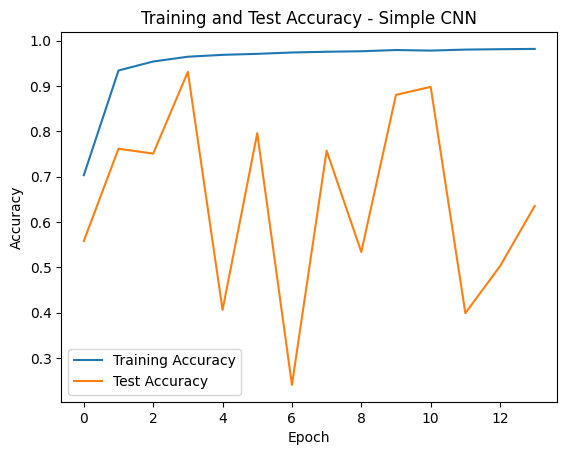

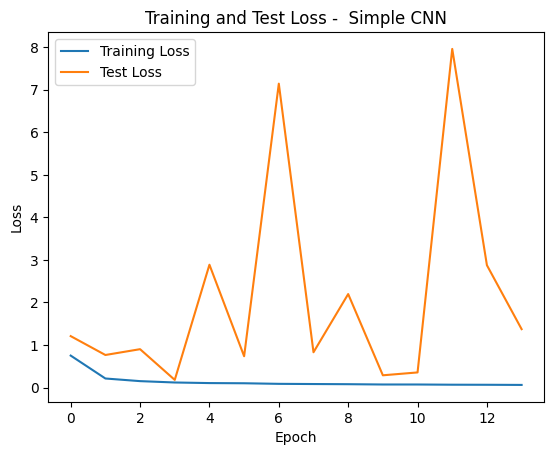

In [20]:
# Plot training and test accuracy
plt.figure()
plt.plot(cnn_history.history['accuracy'], label='Training Accuracy')
plt.plot(cnn_history.history['val_accuracy'], label='Test Accuracy')
plt.title('Training and Test Accuracy - Simple CNN')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and test loss
plt.figure()
plt.plot(cnn_history.history['loss'], label='Training Loss')
plt.plot(cnn_history.history['val_loss'], label='Test Loss')
plt.title('Training and Test Loss -  Simple CNN')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

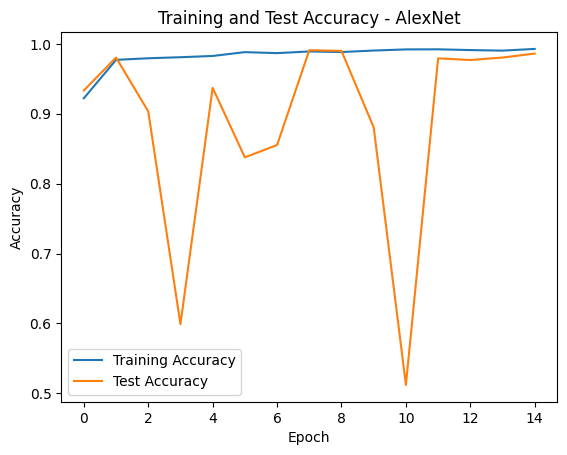

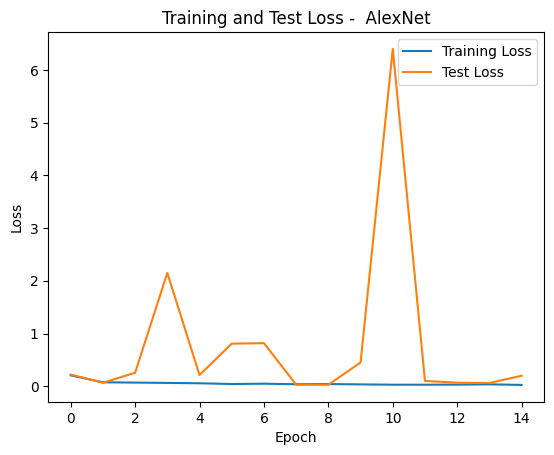

In [21]:
# Plot training and test accuracy
plt.figure()
plt.plot(alexnet_history.history['accuracy'], label='Training Accuracy')
plt.plot(alexnet_history.history['val_accuracy'], label='Test Accuracy')
plt.title('Training and Test Accuracy - AlexNet')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and test loss
plt.figure()
plt.plot(alexnet_history.history['loss'], label='Training Loss')
plt.plot(alexnet_history.history['val_loss'], label='Test Loss')
plt.title('Training and Test Loss -  AlexNet')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

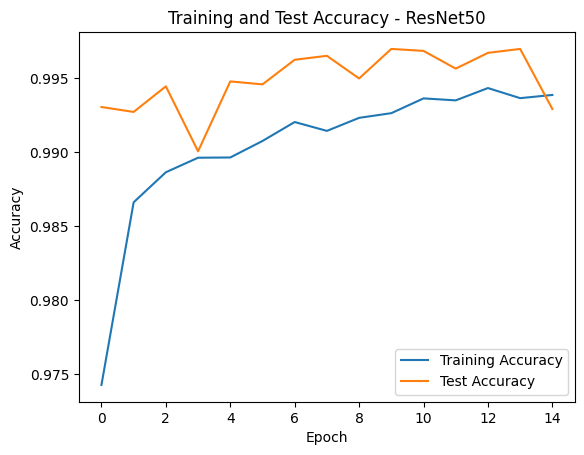

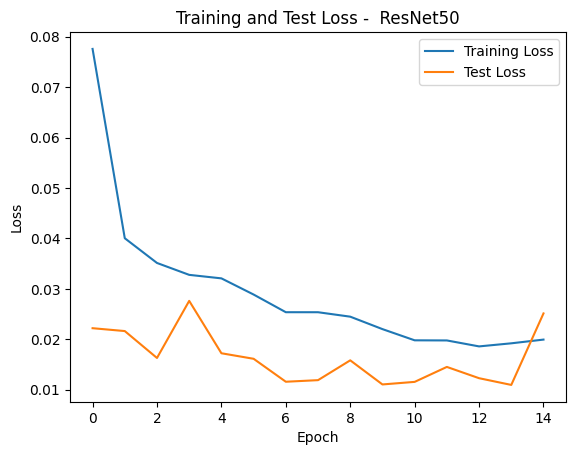

In [22]:
# Plot training and test accuracy
plt.figure()
plt.plot(resnet_history.history['accuracy'], label='Training Accuracy')
plt.plot(resnet_history.history['val_accuracy'], label='Test Accuracy')
plt.title('Training and Test Accuracy - ResNet50')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and test loss
plt.figure()
plt.plot(resnet_history.history['loss'], label='Training Loss')
plt.plot(resnet_history.history['val_loss'], label='Test Loss')
plt.title('Training and Test Loss -  ResNet50')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# t-SNE Visualization for Model Feature Maps

This step visualizes the learned feature representations from each model using **t-SNE** (t-Distributed Stochastic Neighbor Embedding) to reduce high-dimensional feature maps to 2D for better understanding:

- **Feature Extraction**: 
  - Features are extracted from the global average pooling layer of each model (`gap_name` parameter).
  
- **t-SNE Transformation**: 
  - The high-dimensional features are transformed into 2D using t-SNE, making it easier to visualize and understand how the models cluster data.

- **Visualization**:
  - **Scatter plots** display the data points in 2D space, with colors corresponding to different classes.

Plots are generated for:
1. **CNN Model**: Feature maps extracted from `global_average_pooling2d`.
2. **AlexNet Model**: Feature maps from `global_average_pooling2d_1`.
3. **ResNet50 Model**: Feature maps from `global_average_pooling2d_2`.

These visualizations help assess the separability of the classes based on the learned features.


In [23]:
cnn_model = tf.keras.models.load_model("best_cnn.keras")
alexnet_model = tf.keras.models.load_model("best_alexnet.keras")
resnet50_model = tf.keras.models.load_model("best_resnet.keras")

In [24]:
def extract_features_and_labels(model, generator):
    features = []
    labels = []

    for batch_images, batch_labels in generator:
        features_batch = model.predict(batch_images)  # Use the model to extract features
        features.append(features_batch)
        labels.append(np.argmax(batch_labels, axis=-1))  # Convert one-hot to integer labels

    features = np.concatenate(features, axis=0)
    labels = np.concatenate(labels, axis=0)
    
    return features, labels

In [25]:
def plot_tsne(model, gap_name, title):

    features, labels = extract_features_and_labels(model, test_generator)
    
    tsne = TSNE(n_components=2, random_state=42, perplexity=50)
    features = StandardScaler().fit_transform(features)
    features_tsne = tsne.fit_transform(features)

    plt.figure()
    sns.scatterplot(
        x=features_tsne[:, 0],
        y=features_tsne[:, 1],
        hue=labels,
        palette='viridis',
        alpha=0.7
    )
    
    plt.title(f"t-SNE Visualization for {title}")
    plt.xlabel("t-SNE Component 1")
    plt.ylabel("t-SNE Component 2")
    plt.legend(title='Class')
    plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
2/2 ━━━━━━━

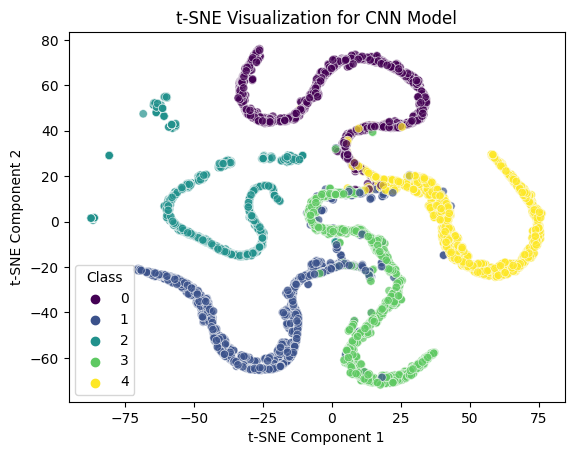

In [26]:
plot_tsne(cnn_model, "global_average_pooling2d", "CNN Model")

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
2/2 ━━━━━━━━━

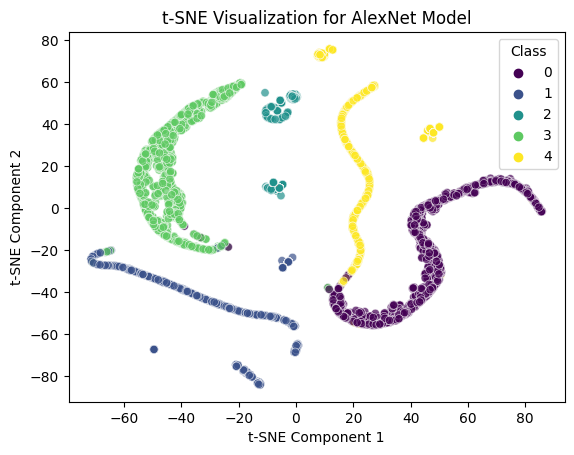

In [27]:
plot_tsne(alexnet_model, "global_average_pooling2d_1", "AlexNet Model")

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━

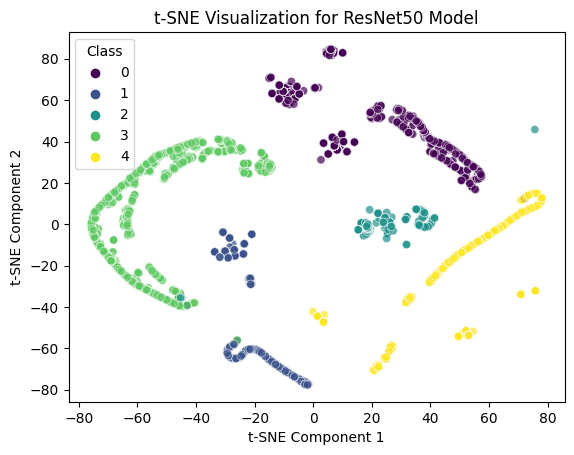

In [28]:
plot_tsne(resnet50_model, "global_average_pooling2d_2", "ResNet50 Model")